In [1]:
%load_ext autoreload
%autoreload 2
import datetime
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
from pprint import pprint
import matplotlib.pyplot as plt

project_dir = os.sep.join([os.getcwd(), '..'])
#sys.path.append(os.sep.join([project_dir, 'src', 'processed']))
processed_data_dir = os.sep.join([project_dir, 'data', 'processed'])

%matplotlib inline

In [2]:
df = pd.read_feather(os.sep.join([processed_data_dir, 'obs_netflow.feather']))

In [3]:
display(df.head())

,DateTime,hour,weekday,month,public_holiday,school_holiday,temperature,wind_speed,humidity,sunshine,...,476,477,478,479,480,482,483,484,486,487
0,2016-04-01 07:00:00+00:00,9,4,4,0,0,2.7,1.4,46.0,60.0,...,0,0,0,0,0,0,0,0,0,0
1,2016-04-01 08:00:00+00:00,10,4,4,0,0,3.8,2.1,46.0,60.0,...,0,0,0,0,0,0,0,0,0,0
2,2016-04-01 09:00:00+00:00,11,4,4,0,0,4.9,2.9,48.0,60.0,...,0,0,0,0,0,0,0,0,0,0
3,2016-04-01 10:00:00+00:00,12,4,4,0,0,6.4,2.8,43.0,60.0,...,0,0,0,0,0,0,0,0,0,0
4,2016-04-01 11:00:00+00:00,13,4,4,0,0,7.6,4.2,37.0,60.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# No nan-values any more!
for v in df.columns:
    na = df[v].isna().sum()
    if na != 0:
        print(v, na)

In [5]:
cols = list(df.columns)
c_start = cols.index('157')
print(f'First station column: {c_start}')
print(f'Number of rows:       {len(df.index)}')
print(cols)

First station column: 19
Number of rows:       11772
['DateTime', 'hour', 'weekday', 'month', 'public_holiday', 'school_holiday', 'temperature', 'wind_speed', 'humidity', 'sunshine', 'precipitation', 'solar_elevation_angle', 'wind_direction_cat', 'weather_fair/cloudy', 'weather_fog/haze', 'weather_thunderstorm', 'weather_rain', 'weather_snow', 'weather_other', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', 

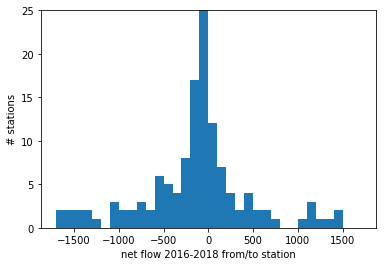

In [6]:
sum_over_time = df.iloc[:, c_start:].sum()
sum_over_time = sum_over_time[sum_over_time.ne(0)]
ax = sum_over_time.plot.hist(bins=range(-1700, 1701, 100))
ax.set_ylim(0, 25)
ax.set_xlabel('net flow 2016-2018 from/to station')
ax.set_ylabel('# stations')
fig = ax.get_figure()
fig.savefig('netflow.svg')

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# First try without CV

In [189]:
import xgboost as xgb

In [190]:
X, y = df.iloc[:, 1:19],df['157']

In [191]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [192]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [193]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10,)

In [194]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

In [195]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
mse = mean_squared_error(y_test, preds)
print("RMSE: %f" % (rmse))
print("MSE: %f" % (mse))

RMSE: 3.373231
MSE: 11.378690


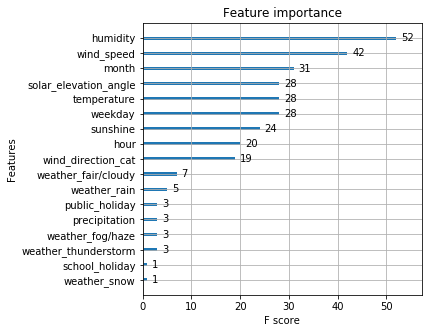

In [196]:
xgb.plot_importance(xg_reg)


# Try with CV

In [205]:
#Choosing a differet set of parameters and a bit of tuning
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 7, 'alpha': 10,"min_child_weight": 5,"gamma":4 }

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=4,
                    num_boost_round=500,early_stopping_rounds=20,metrics="rmse", as_pandas=True, seed=123)

[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 152 extra nodes, 18 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 18 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 162 extra nodes, 18 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 166 extra nodes, 12 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 14 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 174 extra nodes, 12 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tre

[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 28 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 188 extra nodes, 10 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 24 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 22 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 18 pruned nodes, max_depth=7
[14:02:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 28 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 10 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 24 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 14 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 30 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 28 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 128 extra nodes, 34 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 14 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 16 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 30 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 18 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 14 pruned nodes, max_depth=7
[14:02:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 54 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 22 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 18 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 6 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 132 extra nodes, 16 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 34 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree p

[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 16 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 24 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 46 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 40 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 22 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 40 pruned nodes, max_depth=7
[14:02:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree 

[14:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 16 pruned nodes, max_depth=7
[14:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 34 pruned nodes, max_depth=7
[14:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 16 pruned nodes, max_depth=7
[14:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 40 pruned nodes, max_depth=7
[14:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 30 pruned nodes, max_depth=7
[14:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 24 pruned nodes, max_depth=7
[14:02:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pru

In [206]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
100,2.728333,0.021560,3.168304,0.051379
101,2.726523,0.021526,3.168741,0.051421
102,2.722436,0.021102,3.168165,0.051763
103,2.720421,0.021402,3.167889,0.051569
104,2.718899,0.022105,3.167840,0.051400


## The test RMSE only decreases a tad.